# Read in the data

In [1]:
import pandas as pd
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [2]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [9]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score    0.986820
SAT Math Avg. Score                0.972643
SAT Writing Avg. Score             0.987771
sat_score                          1.000000
AP Test Takers                     0.523140
                                     ...   
priority08                              NaN
priority09                              NaN
priority10                              NaN
lat                               -0.121029
lon                               -0.132222
Name: sat_score, Length: 67, dtype: float64


# Plotting survey correlations

In [10]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

rr_s          0.232199
rr_t         -0.023386
rr_p          0.047925
N_s           0.423463
N_t           0.291463
N_p           0.421530
saf_p_11      0.122913
com_p_11     -0.115073
eng_p_11      0.020254
aca_p_11      0.035155
saf_t_11      0.313810
com_t_11      0.082419
eng_t_11      0.036906
aca_t_11      0.132348
saf_s_11      0.337639
com_s_11      0.187370
eng_s_11      0.213822
aca_s_11      0.339435
saf_tot_11    0.318753
com_tot_11    0.077310
eng_tot_11    0.100102
aca_tot_11    0.190966
sat_score     1.000000
Name: sat_score, dtype: float64


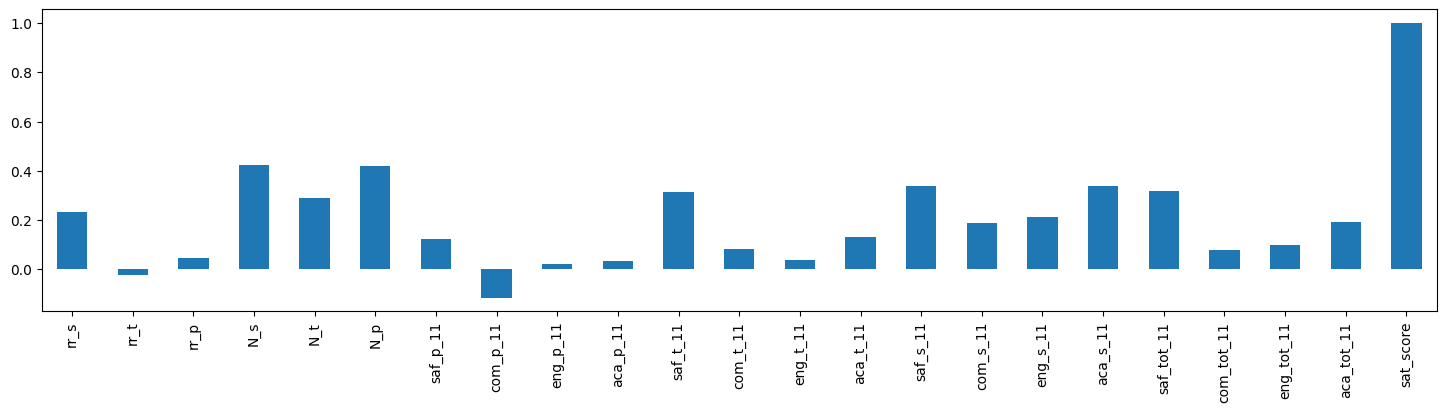

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
    "sat_score",
]
correlations = combined[survey_fields].corr()
correlations = correlations['sat_score']
print(correlations)
correlations.plot.bar(figsize = (18, 4))
plt.show()

Number of responses are correlated with higher SAT scores, as well as reports of safety and academic expectations.

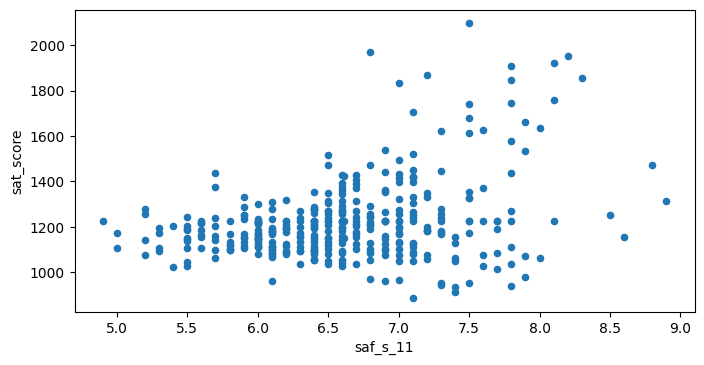

In [12]:

combined.plot.scatter(x="saf_s_11", y="sat_score", figsize = (8, 4))
plt.show()

Higher scores on safety surveys correlate with higher SAT scores

In [13]:
avgboro = combined.groupby('boro')['saf_s_11'].agg(numpy.mean)
print(avgboro)

boro
Bronx            6.606577
Brooklyn         6.370755
Manhattan        6.831370
Queens           6.721875
Staten Island    6.530000
Name: saf_s_11, dtype: float64


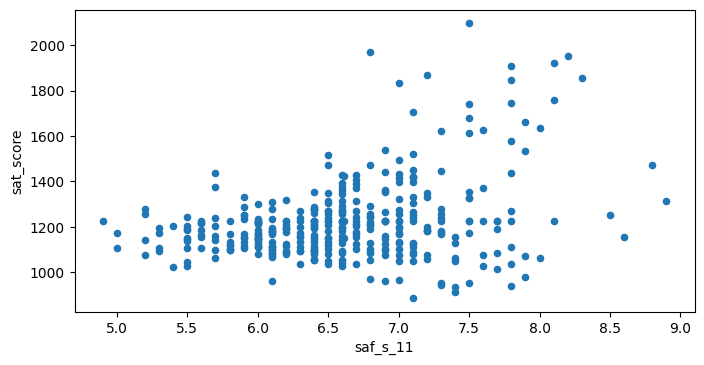

In [15]:
combined.plot.scatter(x="saf_s_11", y="sat_score", figsize = (8, 4))
plt.show()

In [24]:
eth = [['white_per', 'asian_per', 'black_per', 'hispanic_per']]


correlation = combined[['white_per', 'asian_per', 'black_per', 'hispanic_per', 'sat_score']].corr()
correlation = correlation['sat_score']
correlation



white_per       0.620718
asian_per       0.570730
black_per      -0.284139
hispanic_per   -0.396985
sat_score       1.000000
Name: sat_score, dtype: float64

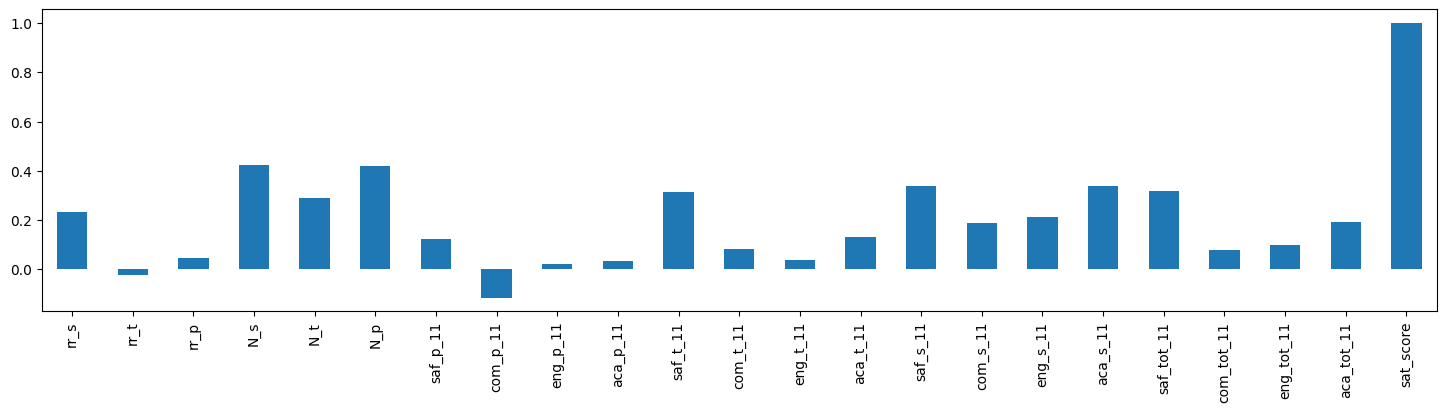

In [25]:
correlations.plot.bar(figsize = (18, 4))

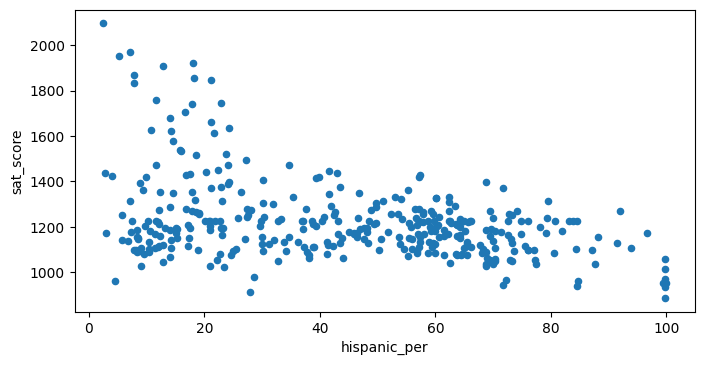

In [26]:
combined.plot.scatter(x="hispanic_per", y="sat_score", figsize = (8, 4))
plt.show()

In [30]:
g = combined[combined['hispanic_per'] > 95]
#print(g)

f = combined[(combined['hispanic_per'] < 10) & (combined['sat_score'] > 1800)]
print(f)

        DBN                                        SCHOOL NAME  \
37   02M475                             STUYVESANT HIGH SCHOOL   
151  10X445                       BRONX HIGH SCHOOL OF SCIENCE   
187  13K430                     BROOKLYN TECHNICAL HIGH SCHOOL   
327  28Q687  QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...   
356  31R605                STATEN ISLAND TECHNICAL HIGH SCHOOL   

    Num of SAT Test Takers  SAT Critical Reading Avg. Score  \
37                     832                            679.0   
151                    731                            632.0   
187                   1277                            587.0   
327                    121                            612.0   
356                    227                            635.0   

     SAT Math Avg. Score  SAT Writing Avg. Score  sat_score  \
37                 735.0                   682.0     2096.0   
151                688.0                   649.0     1969.0   
187                659.0           

            male_per  female_per  sat_score
male_per    1.000000   -1.000000  -0.112062
female_per -1.000000    1.000000   0.112108
sat_score  -0.112062    0.112108   1.000000


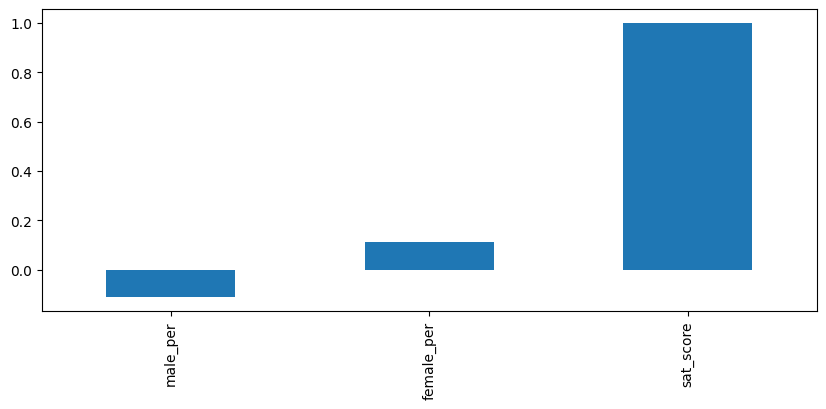

In [39]:
correlation = combined[['male_per', 'female_per', 'sat_score']].corr()
print(correlation)
a = correlation['sat_score']
a.plot.bar(figsize=(10, 4))

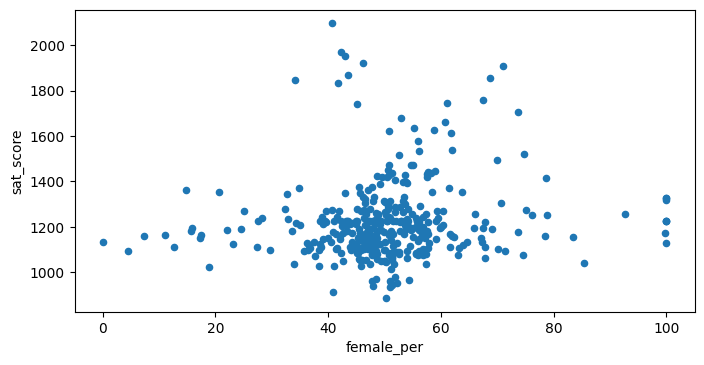

In [40]:
combined.plot.scatter(x="female_per", y="sat_score", figsize = (8, 4))
plt.show()

In [41]:
fsat = combined[(combined['female_per'] > 60) & (combined['sat_score'] > 1700)]
print(fsat)




        DBN                                        SCHOOL NAME  \
5    01M696                     BARD HIGH SCHOOL EARLY COLLEGE   
26   02M416                      ELEANOR ROOSEVELT HIGH SCHOOL   
60   03M479                                 BEACON HIGH SCHOOL   
61   03M485  FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...   
302  25Q525                        TOWNSEND HARRIS HIGH SCHOOL   

    Num of SAT Test Takers  SAT Critical Reading Avg. Score  \
5                      130                            624.0   
26                     127                            572.0   
60                     261                            577.0   
61                     531                            566.0   
302                    278                            621.0   

     SAT Math Avg. Score  SAT Writing Avg. Score  sat_score  \
5                  604.0                   628.0     1856.0   
26                 594.0                   592.0     1758.0   
60                 575.0           

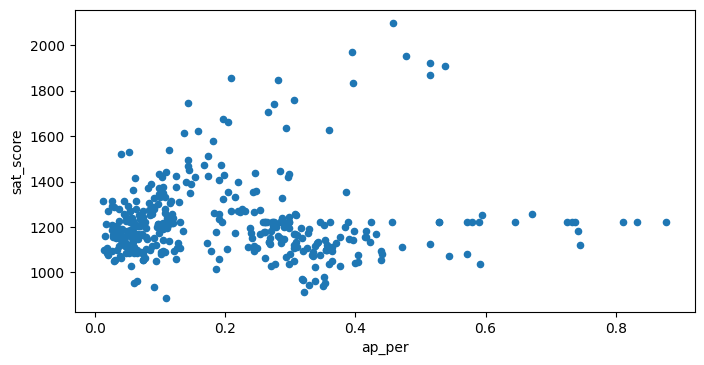

             ap_per  sat_score
ap_per     1.000000   0.057171
sat_score  0.057171   1.000000


In [44]:
combined['ap_per'] = combined['AP Test Takers '] / combined['total_enrollment']

combined.plot.scatter(x="ap_per", y="sat_score", figsize = (8, 4))
plt.show()

a = combined[['ap_per', 'sat_score']].corr()
print(a)




